In [1]:
import os
import pandas as pd
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Fungsi untuk membaca gambar sebagai bytes
def load_image_as_bytes(img_path):
    with open(img_path, "rb") as f:
        return f.read()

# Path ke folder dataset
image_folder = "/kaggle/input/indochart-v2/images/images"
desc_folder = "/kaggle/input/indochart-v2/descriptions/descriptions"
metadata_path = "/kaggle/input/indochart-v2/metadata_indochart_version_2.csv"

# Baca metadata
metadata_df = pd.read_csv(metadata_path)

# Konversi metadata ke dictionary agar pencarian cepat
metadata_dict = metadata_df.set_index("id")[["chartType", "source"]].to_dict(orient="index")
metadata_dict = {f"{k}.png": v for k, v in metadata_dict.items()}

# Ambil daftar file gambar (.png)
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".png")])

In [2]:
# Pasangkan gambar dengan deskripsi menggunakan metadata
data = []
for img_name in tqdm(image_files, desc="Processing images"):
    img_path = os.path.join(image_folder, img_name)
    desc_path = os.path.join(desc_folder, img_name.replace(".png", ".txt"))

    if os.path.exists(desc_path) and img_name in metadata_dict:
        with open(desc_path, "r", encoding="utf-8") as f:
            description = f.read().strip()
        
        # Ambil metadata dari CSV
        chart_type = metadata_dict[img_name]["chartType"]
        source = metadata_dict[img_name]["source"]

        # Tambahkan ke dataset
        data.append({
            "imgname": img_name,
            "query": "Buatkan deskripsi dari grafik berikut ini secara lengkap dan informatif",
            "label": description,
            "image": load_image_as_bytes(img_path),
            "source": source,
            "chartType": chart_type
        })

# Konversi ke DataFrame
df = pd.DataFrame(data)

Processing images: 100%|██████████| 36779/36779 [05:02<00:00, 121.75it/s]


In [3]:
df.head()

,imgname,query,label,image,source,chartType
0,10.png,Buatkan deskripsi dari grafik berikut ini seca...,"Pertama kali dirilis pada awal 2017, Battlegro...",b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,statista,column
1,100.png,Buatkan deskripsi dari grafik berikut ini seca...,Berapa upah minimum? Upah minimum yang diamana...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,statista,bar
2,1000.png,Buatkan deskripsi dari grafik berikut ini seca...,Grafik ini menggambarkan harga tiket rata-rata...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,statista,column
3,10000.png,Buatkan deskripsi dari grafik berikut ini seca...,Statistik ini menunjukkan pangsa pendapatan gr...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,statista,pie
4,10001.png,Buatkan deskripsi dari grafik berikut ini seca...,Statistik ini mewakili total aset General Elec...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,statista,bar


In [4]:
# Stratified split berdasarkan "source" dan "chartType"
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df[["source", "chartType"]], random_state=2025)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[["source", "chartType"]], random_state=2025)

# Path penyimpanan dataset
output_dir = "/kaggle/working/IndoChart"
os.makedirs(output_dir, exist_ok=True)

# Simpan ke Parquet
train_df.to_parquet(os.path.join(output_dir, "train.parquet"), engine="pyarrow", index=False)
val_df.to_parquet(os.path.join(output_dir, "val.parquet"), engine="pyarrow", index=False)
test_df.to_parquet(os.path.join(output_dir, "test.parquet"), engine="pyarrow", index=False)

print("✅ Dataset berhasil dibuat dan disimpan dengan stratifikasi berdasarkan metadata yang diberikan!")

✅ Dataset berhasil dibuat dan disimpan dengan stratifikasi berdasarkan metadata yang diberikan!


In [5]:
df_check = pd.read_parquet("/kaggle/working/IndoChart/train.parquet")
df_check.head()

,imgname,query,label,image,source,chartType
0,T0480_column_a.png,Buatkan deskripsi dari grafik berikut ini seca...,"Di tahun 2023, terdapat 4 unit Rumah Sakit di ...",b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,bps,column
1,T1026_bar_b.png,Buatkan deskripsi dari grafik berikut ini seca...,"Selama tahun 2021, jumlah siswa Sekolah Meneng...",b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,bps,bar
2,8795.png,Buatkan deskripsi dari grafik berikut ini seca...,Statistik ini menyajikan tingkat penetrasi rum...,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,statista,bar
3,T0920_column_c.png,Buatkan deskripsi dari grafik berikut ini seca...,"Dalam tahun 2011, jumlah murid Madrasah Ibtida...",b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,bps,column
4,T0100_pie_a.png,Buatkan deskripsi dari grafik berikut ini seca...,"Pada tahun 2018, total air yang dialirkan kepa...",b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...,bps,pie


In [6]:
import os
from kaggle_secrets import UserSecretsClient
from huggingface_hub import login, HfApi

user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN")
login(token=hf_token)

repo_id = "akunskripsiapillv1/indochart-v2-dataset"

api = HfApi()
api.create_repo(repo_id, repo_type="dataset", exist_ok=True)

files = ["train.parquet", "val.parquet", "test.parquet"]

for file in files:
    api.upload_file(
        path_or_fileobj=f"/kaggle/working/IndoChart/{file}",
        path_in_repo=f"data/{file}",
        repo_id=repo_id,
        repo_type="dataset"
    )
    print(f"✅ {file} berhasil diupload!")

train.parquet:   0%|          | 0.00/2.19G [00:00<?, ?B/s]

✅ train.parquet berhasil diupload!


val.parquet:   0%|          | 0.00/274M [00:00<?, ?B/s]

✅ val.parquet berhasil diupload!


test.parquet:   0%|          | 0.00/273M [00:00<?, ?B/s]

✅ test.parquet berhasil diupload!


In [7]:
from datasets import load_dataset
dataset = load_dataset("akunskripsiapillv1/indochart-v2-dataset")
dataset

train.parquet:   0%|          | 0.00/2.19G [00:00<?, ?B/s]

val.parquet:   0%|          | 0.00/274M [00:00<?, ?B/s]

test.parquet:   0%|          | 0.00/273M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['imgname', 'query', 'label', 'image', 'source', 'chartType'],
        num_rows: 29423
    })
    validation: Dataset({
        features: ['imgname', 'query', 'label', 'image', 'source', 'chartType'],
        num_rows: 3678
    })
    test: Dataset({
        features: ['imgname', 'query', 'label', 'image', 'source', 'chartType'],
        num_rows: 3678
    })
})

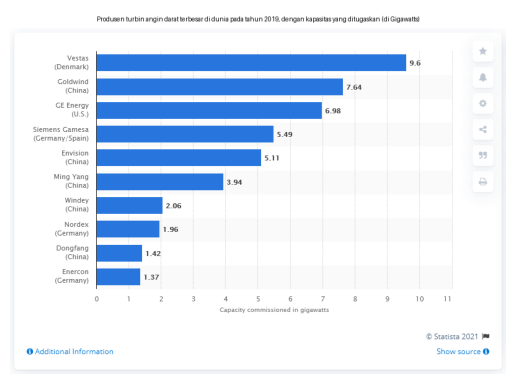

In [11]:
import io
import matplotlib.pyplot as plt
from PIL import Image

img_bytes = dataset["train"][1000]["image"]
img = Image.open(io.BytesIO(img_bytes))

plt.imshow(img)
plt.axis("off")
plt.show()